# 0. Prelude

## 0.1. Install and Import Packages

In [ ]:
# Install Required Packages
%pip install -r requirements.txt

In [139]:
# Zip File Download and Extraction
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# Census Data Extraction
from census import Census
import pandas as pd

# GeoTif file extraction
import geopandas as gpd
from shapely import Point
import rioxarray

#Utilize .env file for api key(s)
from dotenv import dotenv_values
import os

import math

import xgboost as xg
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error as MSE
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
# from pyplotlm import *


## 0.2. Files and URL Register

In [7]:
# File locations for windows file system.

transit_routes_url = 'https://seshat.datasd.org/gis_transit_routes/transit_routes_datasd.zip'
transit_stops_url = 'https://seshat.datasd.org/gis_transit_stops/transit_stops_datasd.zip'
california_tracts_url = 'https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_06_tract.zip'
us_counties_url = 'https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip'
HRPD_url = 'https://data.humdata.org/dataset/eec3a01f-5237-4896-8059-a6be193ca964/resource/58b480a3-afbd-4d1e-bd9f-5ef480bffb61/download/population_usa28_-120_2019-07-01.tif.zip'

transit_routes_file = ".\\Data\\transit_routes\\"
transit_stops_file = ".\\Data\\transit_stops\\"
california_tracts_file = ".\\Data\\california_tracts\\"
us_counties_file = ".\\Data\\us_counties\\"
HRPD_file = '.\\Data\\HRPD\\'

transit_stops_file_name = 'transit_stops_datasd.shp'
california_tracts_file_name = 'tl_2021_06_tract.shp'
us_counties_file_name = 'tl_2021_us_county.shp'
HRPD_file_name = 'population_usa28_-120_2019-07-01.tif'
HRPD_sd_shp_file_name = 'HRPD_sd.shp'

census_file_name = '.\\Data\\census_data.csv'
r_preprocessed_data = '.\\Data\\r_preprocessed_data.csv'

## Loading Census API Key from .env File

In [8]:
env_path = f"{os.getcwd()}\\.env"
config = dotenv_values(env_path)

census_api_key = config["census_api_key"]

#Census object to be used later
c = Census(census_api_key,
           year=2021)

## 0.3. Load Local Datasets

In [9]:
# Only need to run Data Collection and Transformation once.
# after that run this chunk to load the data, so you dont 
# have to redownload and reprocess the data.

# This code chunck will be Placed lower in the final verison.

county_df = gpd\
    .read_file(us_counties_file + us_counties_file_name)\
    .to_crs("EPSG:4326")
county_df = county_df.loc[county_df['NAME']== 'San Diego',]

tract_df = gpd\
    .read_file(california_tracts_file + california_tracts_file_name)\
    .to_crs("EPSG:4326")
tract_df = tract_df.loc[tract_df['COUNTYFP']== '073',]

#We are loading the HRPD file if the file already exists
try:
    HRPD_sd_df = gpd\
        .read_file(HRPD_file + HRPD_sd_shp_file_name)\
        .to_crs("EPSG:4326")
    print("Successfully loaded the HRPD file to a dataframe")
except Exception:
    print("There was an error loading the HRPD file")
    HRPD_sd_df = None
    pass

Successfully loaded the HRPD file to a dataframe


# 1. Data Collection and Transformation

## 1.1. Download & Unzip shape and raster files.

In [545]:
def download_unzip(file_url,file_location):
    with urlopen(file_url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(file_location)

download_unzip(transit_routes_url,transit_routes_file)
download_unzip(transit_stops_url,transit_stops_file)
download_unzip(california_tracts_url,california_tracts_file)
download_unzip(us_counties_url,us_counties_file)
download_unzip(HRPD_url,HRPD_file)

## 1.2. Create Census Data Table

In [10]:
name_list = ['Total'
             , 'Less than 5 mins'
             , '5 to 10 Mins'
             , '10 to 15 Mins'
             , '15 to 20 Mins'
             , '20 to 25 Mins'
             , '25 to 30 Mins'
             , '30 to 35 Mins'
             , '35 to 40 Mins'
             , '40 to 45 Mins'
             , '45 to 60 Mins'
             , '60 to 90 Mins'
             , 'More than 90 Mins'
             ]
key_list = ['B08303_0'+str(i).zfill(2)+'E' for i in range(1, len(name_list)+1)]
demo_name_list = \
    [
        'Total Population',
        'Population With Income to Poverty Level Under 0.50',
        'Population With Income to Poverty Level Between 0.50 and 0.99',
        'Population In Labor Force',
        'Population With Rent >=50 Percent of Household Income',
        'Male Population',
        'Female Population',
        'Population That Utilizes Public Transportation',
        'Commute Time'
    ]
name_list.extend(demo_name_list)

key_list += [
    'B01003_001E',
    'C17002_002E',
    'C17002_003E',
    'B23025_004E',
    'B25070_010E',
    'B01001_002E',
    'B01001_026E',
    'B08301_010E',
    'B08013_001E'
]

In [11]:
#See https://api.census.gov/data/2021/acs/acs5/groups/ for available groups and
#https://api.census.gov/data/2021/acs/acs5/groups/B08303.html for available fields

socio_eco_census = c.acs5.state_county_tract(
    
    state_fips = "06",      # California
    county_fips = "073",    # San Diego
    tract = "*",            # All tracts
    fields = key_list       # All required field ID's
)


In [12]:
census_df = pd.DataFrame(socio_eco_census)
census_df

,B08303_001E,B08303_002E,B08303_003E,B08303_004E,B08303_005E,B08303_006E,B08303_007E,B08303_008E,B08303_009E,B08303_010E,...,C17002_003E,B23025_004E,B25070_010E,B01001_002E,B01001_026E,B08301_010E,B08013_001E,state,county,tract
0,982.0,7.0,68.0,152.0,261.0,152.0,75.0,158.0,0.0,44.0,...,6.0,1222.0,11.0,1425.0,1531.0,0.0,20640.0,06,073,000100
1,935.0,21.0,166.0,161.0,184.0,122.0,10.0,117.0,19.0,52.0,...,54.0,1130.0,84.0,1018.0,1291.0,9.0,18720.0,06,073,000201
2,2184.0,23.0,118.0,408.0,553.0,444.0,98.0,261.0,0.0,21.0,...,0.0,2570.0,243.0,2160.0,1956.0,85.0,49170.0,06,073,000202
3,1376.0,29.0,23.0,352.0,245.0,224.0,69.0,150.0,49.0,12.0,...,308.0,1614.0,200.0,1204.0,1046.0,55.0,34765.0,06,073,000301
4,1860.0,36.0,397.0,258.0,337.0,226.0,55.0,342.0,57.0,21.0,...,169.0,2135.0,239.0,1599.0,1443.0,96.0,36715.0,06,073,000302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,2030.0,40.0,210.0,372.0,304.0,273.0,146.0,307.0,64.0,65.0,...,318.0,1235.0,107.0,2155.0,1445.0,150.0,47225.0,06,073,021900
733,2040.0,0.0,214.0,181.0,578.0,257.0,131.0,262.0,23.0,60.0,...,290.0,2195.0,354.0,2195.0,2309.0,185.0,57985.0,06,073,022000
734,708.0,0.0,161.0,137.0,52.0,48.0,10.0,89.0,10.0,20.0,...,0.0,989.0,96.0,1167.0,1113.0,0.0,18210.0,06,073,022101
735,1950.0,0.0,163.0,313.0,446.0,188.0,47.0,231.0,127.0,16.0,...,336.0,3118.0,275.0,3941.0,4076.0,16.0,53195.0,06,073,022102


### 1.2.1. Rename Columns to appropriate title

In [13]:
column_rename = {key_list[i]: name_list[i] for i in range(0,len(key_list))}

census_df = census_df.rename(columns=column_rename)

census_df

,Total,Less than 5 mins,5 to 10 Mins,10 to 15 Mins,15 to 20 Mins,20 to 25 Mins,25 to 30 Mins,30 to 35 Mins,35 to 40 Mins,40 to 45 Mins,...,Population With Income to Poverty Level Between 0.50 and 0.99,Population In Labor Force,Population With Rent >=50 Percent of Household Income,Male Population,Female Population,Population That Utilizes Public Transportation,Commute Time,state,county,tract
0,982.0,7.0,68.0,152.0,261.0,152.0,75.0,158.0,0.0,44.0,...,6.0,1222.0,11.0,1425.0,1531.0,0.0,20640.0,06,073,000100
1,935.0,21.0,166.0,161.0,184.0,122.0,10.0,117.0,19.0,52.0,...,54.0,1130.0,84.0,1018.0,1291.0,9.0,18720.0,06,073,000201
2,2184.0,23.0,118.0,408.0,553.0,444.0,98.0,261.0,0.0,21.0,...,0.0,2570.0,243.0,2160.0,1956.0,85.0,49170.0,06,073,000202
3,1376.0,29.0,23.0,352.0,245.0,224.0,69.0,150.0,49.0,12.0,...,308.0,1614.0,200.0,1204.0,1046.0,55.0,34765.0,06,073,000301
4,1860.0,36.0,397.0,258.0,337.0,226.0,55.0,342.0,57.0,21.0,...,169.0,2135.0,239.0,1599.0,1443.0,96.0,36715.0,06,073,000302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,2030.0,40.0,210.0,372.0,304.0,273.0,146.0,307.0,64.0,65.0,...,318.0,1235.0,107.0,2155.0,1445.0,150.0,47225.0,06,073,021900
733,2040.0,0.0,214.0,181.0,578.0,257.0,131.0,262.0,23.0,60.0,...,290.0,2195.0,354.0,2195.0,2309.0,185.0,57985.0,06,073,022000
734,708.0,0.0,161.0,137.0,52.0,48.0,10.0,89.0,10.0,20.0,...,0.0,989.0,96.0,1167.0,1113.0,0.0,18210.0,06,073,022101
735,1950.0,0.0,163.0,313.0,446.0,188.0,47.0,231.0,127.0,16.0,...,336.0,3118.0,275.0,3941.0,4076.0,16.0,53195.0,06,073,022102


### 1.2.2. Remove trivial columns and rows.

In [14]:
census_df = census_df.drop(columns=['state','county'], index=[736,269,280])

### 1.2.3. Add Mean Time Column

In [16]:
commute_mean_time = [0 for x in range(734)]
for i in range(1,10):
    commute_mean_time = commute_mean_time + \
        census_df[name_list[i]]*(2.5+(i-1)*5)

commute_mean_time = commute_mean_time +  census_df[name_list[10]]*52.75
commute_mean_time = commute_mean_time +  census_df[name_list[11]]*75
commute_mean_time = commute_mean_time/census_df['Total']

# Ignoring 90 mins for now.
# commute_mean_time.mean()

census_df['Mean Time'] = commute_mean_time

In [20]:
census_df['Mean Time 2'] = census_df['Commute Time']/census_df['Total']

### 1.2.4. Save Dataframe to CSV file

In [552]:
census_df.to_csv(census_file_name,index=False)
census_df

,Total,Less than 5 mins,5 to 10 Mins,10 to 15 Mins,15 to 20 Mins,20 to 25 Mins,25 to 30 Mins,30 to 35 Mins,35 to 40 Mins,40 to 45 Mins,...,Total Population,Population With Income to Poverty Level Under 0.50,Population With Income to Poverty Level Between 0.50 and 0.99,Population In Labor Force,Population With Rent >=50 Percent of Household Income,Male Population,Female Population,Population That Utilizes Public Transportation,tract,Mean Time
0,982.0,7.0,68.0,152.0,261.0,152.0,75.0,158.0,0.0,44.0,...,2956.0,42.0,6.0,1222.0,11.0,1425.0,1531.0,0.0,000100,23.062627
1,935.0,21.0,166.0,161.0,184.0,122.0,10.0,117.0,19.0,52.0,...,2309.0,92.0,54.0,1130.0,84.0,1018.0,1291.0,9.0,000201,21.581283
2,2184.0,23.0,118.0,408.0,553.0,444.0,98.0,261.0,0.0,21.0,...,4116.0,171.0,0.0,2570.0,243.0,2160.0,1956.0,85.0,000202,23.605311
3,1376.0,29.0,23.0,352.0,245.0,224.0,69.0,150.0,49.0,12.0,...,2250.0,78.0,308.0,1614.0,200.0,1204.0,1046.0,55.0,000301,24.584121
4,1860.0,36.0,397.0,258.0,337.0,226.0,55.0,342.0,57.0,21.0,...,3042.0,33.0,169.0,2135.0,239.0,1599.0,1443.0,96.0,000302,20.734409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,658.0,3.0,48.0,71.0,202.0,150.0,35.0,29.0,43.0,0.0,...,2017.0,36.0,13.0,894.0,33.0,962.0,1055.0,7.0,021800,24.862842
732,2030.0,40.0,210.0,372.0,304.0,273.0,146.0,307.0,64.0,65.0,...,3600.0,236.0,318.0,1235.0,107.0,2155.0,1445.0,150.0,021900,24.975369
733,2040.0,0.0,214.0,181.0,578.0,257.0,131.0,262.0,23.0,60.0,...,4504.0,93.0,290.0,2195.0,354.0,2195.0,2309.0,185.0,022000,21.515319
734,708.0,0.0,161.0,137.0,52.0,48.0,10.0,89.0,10.0,20.0,...,2280.0,315.0,0.0,989.0,96.0,1167.0,1113.0,0.0,022101,28.597458


## 1.3. Convert HRPD Raster Data to Shapefile

In [553]:
#We are creating the HRPD df and file if it wasn't loaded successfully earlier
if HRPD_sd_df is None:
    san_deigo_polygon = county_df.loc[539,'geometry']

    # Takes some Time (35sec on desktop)
    HRPD_tif = rioxarray.open_rasterio(HRPD_file + HRPD_file_name, cache = False)
    # If an OOM (or other) error occurs we are utilizing the from_disk option
    try:
        HRPD_sd_tif = HRPD_tif.rio.clip([san_deigo_polygon], from_disk = False)
    except:
        print("Utilizing the rio.clip from_disk flag")
        HRPD_sd_tif = HRPD_tif.rio.clip([san_deigo_polygon], from_disk = True)
    HRPD_tif = HRPD_sd_tif.rio.reproject("EPSG:4326", cache = False)
    # Takes some Time (10sec on desktop)
    HRPD_sd_df = HRPD_sd_tif[0].to_dataframe('Population').dropna()
    HRPD_sd_df['geometry'] = \
        [Point(index[1],index[0]) for index,row in HRPD_sd_df.iterrows()]
    HRPD_sd_df = gpd.GeoDataFrame(HRPD_sd_df['Population'],
                                geometry = HRPD_sd_df['geometry'])\
                                    .reset_index(drop=True)
    # Takes some Time (25sec on desktop)
    HRPD_sd_df.to_file(HRPD_file + HRPD_sd_shp_file_name, 
                    index=False,
                    crs='EPSG:4326', windowed = True)


In [21]:
HRPD_sd_df

,Population,geometry
0,0.134667,POINT (-117.37083 33.49083)
1,0.908454,POINT (-117.40111 33.48444)
2,0.908454,POINT (-117.40111 33.48389)
3,0.908454,POINT (-117.40000 33.48361)
4,0.908454,POINT (-117.37444 33.48111)
...,...,...
797661,0.074160,POINT (-117.11417 32.53556)
797662,0.074160,POINT (-117.11389 32.53556)
797663,0.074160,POINT (-117.11889 32.53528)
797664,0.074160,POINT (-117.11694 32.53528)


## 1.4. Create other paramerters by processing data

### 1.4.1. Create Pop Centers, tract Pop and Distance from Hub

In [22]:
def pop_center(pop_table):
    x = 0
    y = 0
    pop_total = 0
    for index,row in pop_table.iterrows():
        x += row['geometry'].x*row['Population']
        y += row['geometry'].y*row['Population']
        pop_total += row['Population']

    return Point(x/pop_total ,y/pop_total)

tract_df['tract'] = pd.to_numeric(tract_df['TRACTCE'])
tract_df = tract_df[tract_df['tract'] != 990100]
tract_df = tract_df[tract_df['tract'] != 10016]
tract_df = tract_df[tract_df['tract'] != 9902]

# Takes some Time (50sec on desktop)
pop_center_list = [pop_center(HRPD_sd_df.clip(row['geometry'])) for index, row in tract_df.iterrows()]


In [80]:
def point_distance(point_1,point_2):
    return math.sqrt((point_1.x-point_2.x)**2 + (point_1.y-point_2.y)**2)

commute_hub_1 = tract_df.loc[tract_df['tract'] == 5403,'geometry'].centroid

pop_distance = [point_distance(pop_center,commute_hub_1 ) for pop_center in pop_center_list]

C:\Users\Kabir\AppData\Local\Temp\ipykernel_25088\4055002358.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commute_hub_1 = tract_df.loc[tract_df['tract'] == 5403,'geometry'].centroid
C:\Users\Kabir\AppData\Local\Temp\ipykernel_25088\4055002358.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.sqrt((point_1.x-point_2.x)**2 + (point_1.y-point_2.y)**2)


In [82]:
tract_df['distance from commute hub 1'] = pop_distance

### 1.4.2. Create Stops and Route Length in Tracts

In [83]:
transit_stops_df = gpd.read_file(transit_stops_file + transit_stops_file_name).to_crs("EPSG:4326")
stop_count = []
# stop_count_no_buffer = []
for index,row in tract_df.iterrows():

    tract_polygon = row['geometry']

    overlapping_stops = transit_stops_df[transit_stops_df.within(tract_polygon.buffer(0.0001, join_style=2))]
    # overlapping_stops_no_buff = transit_stops_df[transit_stops_df.within(tract_polygon)]

    total_stop_count = len(overlapping_stops["stop_uid"].unique())
    # total_stop_count_no_buff = len(overlapping_stops_no_buff["stop_uid"].unique())

    stop_count.append(total_stop_count)
    # stop_count_no_buffer.append(total_stop_count_no_buff)

tract_df['stop_count']  = stop_count

In [84]:
transit_routes_df = gpd.read_file(transit_routes_file + 'transit_routes_datasd.shp').to_crs("EPSG:4326")
total_route_meters_list = []
total_route_count_list = []
#Adding area in meters to tract df
tract_df["tract_area_m"] = tract_df.to_crs(crs = 3857).area

# Remember to Buffer the tract polygons, so the correctly include the stops around them
for index, row in tract_df.iterrows():

    
    tract_polygon = row['geometry']

    overlapping_routes = gpd.clip(transit_routes_df, tract_polygon.buffer(0.0001, join_style=2))

    #We are calculating the total length of meters of the routes and counting the # of overlapping routes
    #3857 for meters
    total_route_meters = sum(overlapping_routes.to_crs(crs = 3857).length)
    total_route_count = len(overlapping_routes["route_id"].unique())
    
    #We are assigning this values to our tract df copy
    total_route_meters_list.append(total_route_meters)
    total_route_count_list.append(total_route_count)


tract_df["total_route_length_m"] = total_route_meters_list
tract_df["total_route_count"] = total_route_count_list

#We are creating a ratio of the total route meters to area
tract_df["total_route_length_to_area_ratio"] = tract_df["total_route_length_m"] / \
        tract_df["tract_area_m"]

tract_df

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,tract,distance from commute hub 1,stop_count,tract_area_m,total_route_length_m,total_route_count,total_route_length_to_area_ratio
1627,06,073,007702,06073007702,77.02,Census Tract 77.02,G5020,S,618401,0,+32.7899000,-117.2350654,"POLYGON ((-117.23910 32.79396, -117.23873 32.7...",7702,0.108943,13,8.774833e+05,15514.691195,1,0.017681
1628,06,073,020308,06073020308,203.08,Census Tract 203.08,G5020,S,1211945,0,+33.1373657,-117.0979771,"POLYGON ((-117.10405 33.14203, -117.10390 33.1...",20308,0.434142,10,1.733142e+06,5906.914335,3,0.003408
1654,06,073,017801,06073017801,178.01,Census Tract 178.01,G5020,S,4345848,116020,+33.1735608,-117.3403004,"POLYGON ((-117.34962 33.17620, -117.34904 33.1...",17801,0.490211,29,6.385392e+06,56653.642941,5,0.008872
1670,06,073,012303,06073012303,123.03,Census Tract 123.03,G5020,S,1537489,28342,+32.6514389,-117.0724250,"POLYGON ((-117.08635 32.65061, -117.08626 32.6...",12303,0.105671,7,2.214994e+06,26973.265108,3,0.012178
1671,06,073,004200,06073004200,42,Census Tract 42,G5020,S,2493055,0,+32.7293502,-117.1194471,"POLYGON ((-117.12547 32.72395, -117.12547 32.7...",4200,0.048575,0,3.532758e+06,20311.839693,3,0.005750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9039,06,073,000400,06073000400,4,Census Tract 4,G5020,S,1177454,0,+32.7533382,-117.1630702,"POLYGON ((-117.17087 32.75865, -117.17019 32.7...",400,0.043417,17,1.669388e+06,69188.374162,9,0.041445
9040,06,073,000500,06073000500,5,Census Tract 5,G5020,S,1108651,0,+32.7605138,-117.1519499,"POLYGON ((-117.16151 32.75890, -117.16149 32.7...",500,0.053264,3,1.572093e+06,20911.634108,7,0.013302
9041,06,073,000600,06073000600,6,Census Tract 6,G5020,S,932839,0,+32.7529575,-117.1518411,"POLYGON ((-117.16083 32.75827, -117.16077 32.7...",600,0.045762,15,1.322567e+06,118287.518618,10,0.089438
9051,06,073,003103,06073003103,31.03,Census Tract 31.03,G5020,S,2039646,0,+32.7070141,-117.0441008,"POLYGON ((-117.05533 32.70560, -117.05532 32.7...",3103,0.120590,21,2.888829e+06,47274.516340,4,0.016365


# 2. XGB Classifier

In [85]:
tract_df = tract_df.drop(columns=['STATEFP','COUNTYFP','TRACTCE','GEOID','NAME','NAMELSAD','MTFCC','FUNCSTAT','ALAND','AWATER','INTPTLAT','INTPTLON','geometry'])

In [86]:
tract_df = tract_df.sort_values(by=['tract']).reset_index(drop=True)
tract_df

,tract,distance from commute hub 1,stop_count,tract_area_m,total_route_length_m,total_route_count,total_route_length_to_area_ratio
0,100,0.049083,7,2.178075e+06,8986.306744,1,0.004126
1,201,0.045199,7,1.225291e+06,8083.022292,2,0.006597
2,202,0.038100,11,1.851316e+06,23632.213878,2,0.012765
3,301,0.036690,8,5.695554e+05,18651.821141,5,0.032748
4,302,0.035475,16,7.044608e+05,50905.163268,9,0.072261
...,...,...,...,...,...,...,...
729,21800,0.029002,6,2.029660e+06,12156.220372,2,0.005989
730,21900,0.061919,34,1.344498e+07,153304.277195,10,0.011402
731,22000,0.082171,10,1.033846e+06,27147.294101,6,0.026259
732,22101,0.454105,53,1.790678e+07,72954.473797,4,0.004074


In [87]:
census_df['tract'] = pd.to_numeric(census_df['tract'])
census_df = census_df.sort_values(by=['tract']).reset_index(drop=True)
census_df

,Total,Less than 5 mins,5 to 10 Mins,10 to 15 Mins,15 to 20 Mins,20 to 25 Mins,25 to 30 Mins,30 to 35 Mins,35 to 40 Mins,40 to 45 Mins,...,Population With Income to Poverty Level Between 0.50 and 0.99,Population In Labor Force,Population With Rent >=50 Percent of Household Income,Male Population,Female Population,Population That Utilizes Public Transportation,Commute Time,tract,Mean Time,Mean Time 2
0,982.0,7.0,68.0,152.0,261.0,152.0,75.0,158.0,0.0,44.0,...,6.0,1222.0,11.0,1425.0,1531.0,0.0,20640.0,100,23.062627,21.018330
1,935.0,21.0,166.0,161.0,184.0,122.0,10.0,117.0,19.0,52.0,...,54.0,1130.0,84.0,1018.0,1291.0,9.0,18720.0,201,21.581283,20.021390
2,2184.0,23.0,118.0,408.0,553.0,444.0,98.0,261.0,0.0,21.0,...,0.0,2570.0,243.0,2160.0,1956.0,85.0,49170.0,202,23.605311,22.513736
3,1376.0,29.0,23.0,352.0,245.0,224.0,69.0,150.0,49.0,12.0,...,308.0,1614.0,200.0,1204.0,1046.0,55.0,34765.0,301,24.584121,25.265262
4,1860.0,36.0,397.0,258.0,337.0,226.0,55.0,342.0,57.0,21.0,...,169.0,2135.0,239.0,1599.0,1443.0,96.0,36715.0,302,20.734409,19.739247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,658.0,3.0,48.0,71.0,202.0,150.0,35.0,29.0,43.0,0.0,...,13.0,894.0,33.0,962.0,1055.0,7.0,14915.0,21800,24.862842,22.667173
730,2030.0,40.0,210.0,372.0,304.0,273.0,146.0,307.0,64.0,65.0,...,318.0,1235.0,107.0,2155.0,1445.0,150.0,47225.0,21900,24.975369,23.263547
731,2040.0,0.0,214.0,181.0,578.0,257.0,131.0,262.0,23.0,60.0,...,290.0,2195.0,354.0,2195.0,2309.0,185.0,57985.0,22000,21.515319,28.424020
732,708.0,0.0,161.0,137.0,52.0,48.0,10.0,89.0,10.0,20.0,...,0.0,989.0,96.0,1167.0,1113.0,0.0,18210.0,22101,28.597458,25.720339


In [88]:
#Renaming to camel case in tract_df
tract_df['population'] = census_df['Total Population']
tract_df['population_with_income_to_poverty_level_under_0.50'] = \
    census_df['Population With Income to Poverty Level Under 0.50']
tract_df['population_with_income_to_poverty_level_between_0.50_and_0.99'] = \
    census_df['Population With Income to Poverty Level Between 0.50 and 0.99']
tract_df['population_in_labor_force'] = census_df['Population In Labor Force']
tract_df['population_with_rent_>=50_percent_of_household_income'] = \
    census_df['Population With Rent >=50 Percent of Household Income']
tract_df['male_population'] = \
    census_df['Male Population']
tract_df['female_population'] = \
    census_df['Female Population']
tract_df['population_that_utilizes_public_transportation'] = \
    census_df['Population That Utilizes Public Transportation']
tract_df['distance_from_commute_hub_1'] = \
    tract_df['distance from commute hub 1']
tract_df

,tract,distance from commute hub 1,stop_count,tract_area_m,total_route_length_m,total_route_count,total_route_length_to_area_ratio,population,population_with_income_to_poverty_level_under_0.50,population_with_income_to_poverty_level_between_0.50_and_0.99,population_in_labor_force,population_with_rent_>=50_percent_of_household_income,male_population,female_population,population_that_utilizes_public_transportation,distance_from_commute_hub_1
0,100,0.049083,7,2.178075e+06,8986.306744,1,0.004126,2956.0,42.0,6.0,1222.0,11.0,1425.0,1531.0,0.0,0.049083
1,201,0.045199,7,1.225291e+06,8083.022292,2,0.006597,2309.0,92.0,54.0,1130.0,84.0,1018.0,1291.0,9.0,0.045199
2,202,0.038100,11,1.851316e+06,23632.213878,2,0.012765,4116.0,171.0,0.0,2570.0,243.0,2160.0,1956.0,85.0,0.038100
3,301,0.036690,8,5.695554e+05,18651.821141,5,0.032748,2250.0,78.0,308.0,1614.0,200.0,1204.0,1046.0,55.0,0.036690
4,302,0.035475,16,7.044608e+05,50905.163268,9,0.072261,3042.0,33.0,169.0,2135.0,239.0,1599.0,1443.0,96.0,0.035475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,21800,0.029002,6,2.029660e+06,12156.220372,2,0.005989,2017.0,36.0,13.0,894.0,33.0,962.0,1055.0,7.0,0.029002
730,21900,0.061919,34,1.344498e+07,153304.277195,10,0.011402,3600.0,236.0,318.0,1235.0,107.0,2155.0,1445.0,150.0,0.061919
731,22000,0.082171,10,1.033846e+06,27147.294101,6,0.026259,4504.0,93.0,290.0,2195.0,354.0,2195.0,2309.0,185.0,0.082171
732,22101,0.454105,53,1.790678e+07,72954.473797,4,0.004074,2280.0,315.0,0.0,989.0,96.0,1167.0,1113.0,0.0,0.454105


In [90]:
census_df[census_df["Mean Time"].isna()]
# census_df = census_df.drop([269,280])
# tract_df = tract_df.drop([269,280])
tract_df.drop(columns=['distance from commute hub 1'],inplace=True)
tract_df

,tract,stop_count,tract_area_m,total_route_length_m,total_route_count,total_route_length_to_area_ratio,population,population_with_income_to_poverty_level_under_0.50,population_with_income_to_poverty_level_between_0.50_and_0.99,population_in_labor_force,population_with_rent_>=50_percent_of_household_income,male_population,female_population,population_that_utilizes_public_transportation,distance_from_commute_hub_1
0,100,7,2.178075e+06,8986.306744,1,0.004126,2956.0,42.0,6.0,1222.0,11.0,1425.0,1531.0,0.0,0.049083
1,201,7,1.225291e+06,8083.022292,2,0.006597,2309.0,92.0,54.0,1130.0,84.0,1018.0,1291.0,9.0,0.045199
2,202,11,1.851316e+06,23632.213878,2,0.012765,4116.0,171.0,0.0,2570.0,243.0,2160.0,1956.0,85.0,0.038100
3,301,8,5.695554e+05,18651.821141,5,0.032748,2250.0,78.0,308.0,1614.0,200.0,1204.0,1046.0,55.0,0.036690
4,302,16,7.044608e+05,50905.163268,9,0.072261,3042.0,33.0,169.0,2135.0,239.0,1599.0,1443.0,96.0,0.035475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,21800,6,2.029660e+06,12156.220372,2,0.005989,2017.0,36.0,13.0,894.0,33.0,962.0,1055.0,7.0,0.029002
730,21900,34,1.344498e+07,153304.277195,10,0.011402,3600.0,236.0,318.0,1235.0,107.0,2155.0,1445.0,150.0,0.061919
731,22000,10,1.033846e+06,27147.294101,6,0.026259,4504.0,93.0,290.0,2195.0,354.0,2195.0,2309.0,185.0,0.082171
732,22101,53,1.790678e+07,72954.473797,4,0.004074,2280.0,315.0,0.0,989.0,96.0,1167.0,1113.0,0.0,0.454105


## 2.1. Tree Regerssion

In [108]:
x = tract_df.iloc[:,1:]
y = census_df['Mean Time 2']

train_dmatrix = xg.DMatrix(data = x, label = y) 

param = {"booster":"gblinear", "objective":"reg:linear"} 

xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10) 
pred = xgb_r.predict(train_dmatrix) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y, pred)) 
print("RMSE : % f" %(rmse))
print(np.std(y))
xgb_r.get_score(importance_type = "weight")

RMSE :  4.377458
4.838720144243636


c:\Users\Kabir\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


{'stop_count': -0.021017588675022125,
 'tract_area_m': 3.171081841557566e-09,
 'total_route_length_m': 3.5974537695437903e-06,
 'total_route_count': -0.12799285352230072,
 'total_route_length_to_area_ratio': -6.280943393707275,
 'population': 7.718982669757679e-05,
 'population_with_income_to_poverty_level_under_0.50': 0.00032971639302559197,
 'population_with_income_to_poverty_level_between_0.50_and_0.99': 0.0014870730228722095,
 'population_in_labor_force': 0.00016095861792564392,
 'population_with_rent_>=50_percent_of_household_income': -0.0051637087017297745,
 'male_population': 9.811665950110182e-05,
 'female_population': 0.00014642540190834552,
 'population_that_utilizes_public_transportation': 0.003905503312125802,
 'distance_from_commute_hub_1': 6.5233473777771}

RMSE :  2.211588
4.838720144243636


<Axes: >

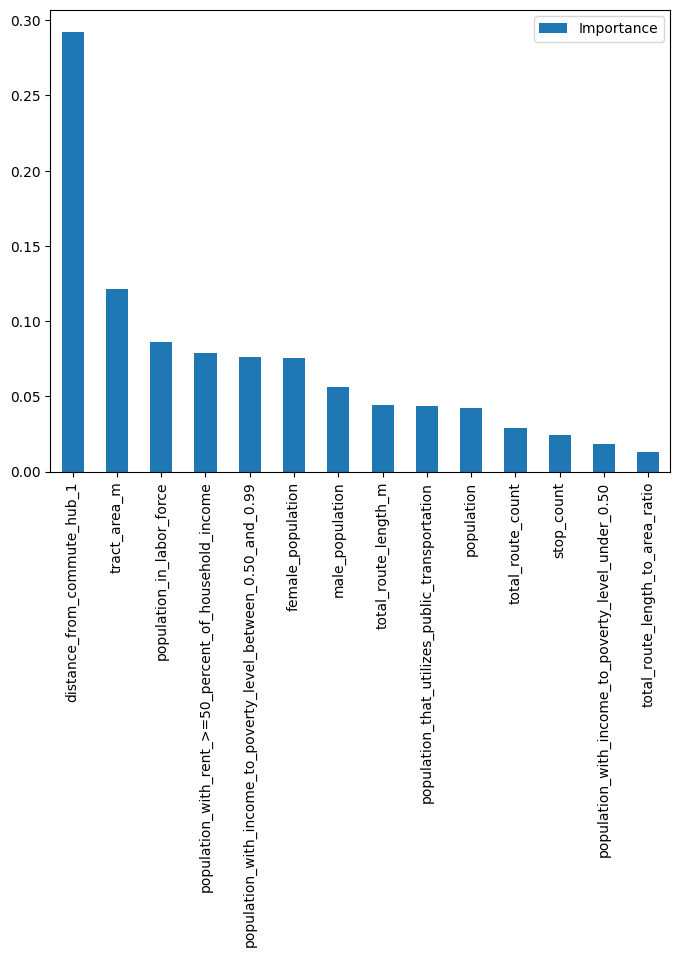

In [112]:
regr_2 = DecisionTreeRegressor(max_depth=10)
regr_2.fit(x, y)
y_2 = regr_2.predict(x)

rmse = np.sqrt(MSE(y, y_2)) 
print("RMSE : % f" %(rmse))
print(np.std(y))

feat_importances = pd.DataFrame(regr_2.feature_importances_, index=x.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

[Text(0.5, 0.875, 'x[13] <= 0.445\nsquared_error = 23.413\nsamples = 734\nvalue = 26.395'),
 Text(0.25, 0.625, 'x[13] <= 0.12\nsquared_error = 19.442\nsamples = 611\nvalue = 25.641'),
 Text(0.125, 0.375, 'x[7] <= 121.5\nsquared_error = 16.736\nsamples = 209\nvalue = 24.162'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'x[1] <= 42139416.0\nsquared_error = 19.123\nsamples = 402\nvalue = 26.409'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'x[1] <= 18004560.0\nsquared_error = 26.281\nsamples = 123\nvalue = 30.141'),
 Text(0.625, 0.375, 'x[13] <= 0.541\nsquared_error = 14.86\nsamples = 90\nvalue = 28.832'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'x[10] <= 15407.5\nsquared_error = 40.029\nsamples = 33\nvalue = 33.709'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

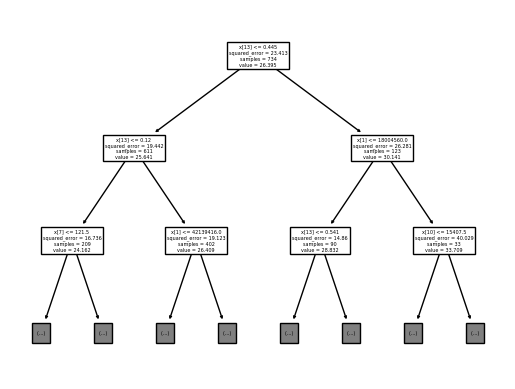

In [133]:
tree.plot_tree(regr_2,max_depth=2)

# 2.2. Tree Classification

Accuracy: 85.33%


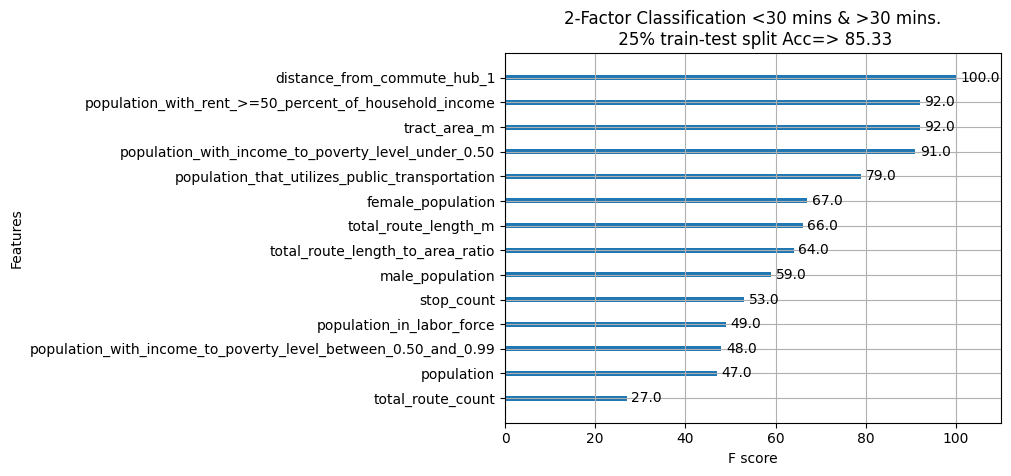

In [154]:
y = [int(row[1:7].sum() < row[7:13].sum()) for i,row in census_df.iterrows()]


seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_importance(model)
plt.title("2-Factor Classification <30 mins & >30 mins.\n 25% train-test split ACC. => 85.33")
plt.show()

Accuracy: 86.41%


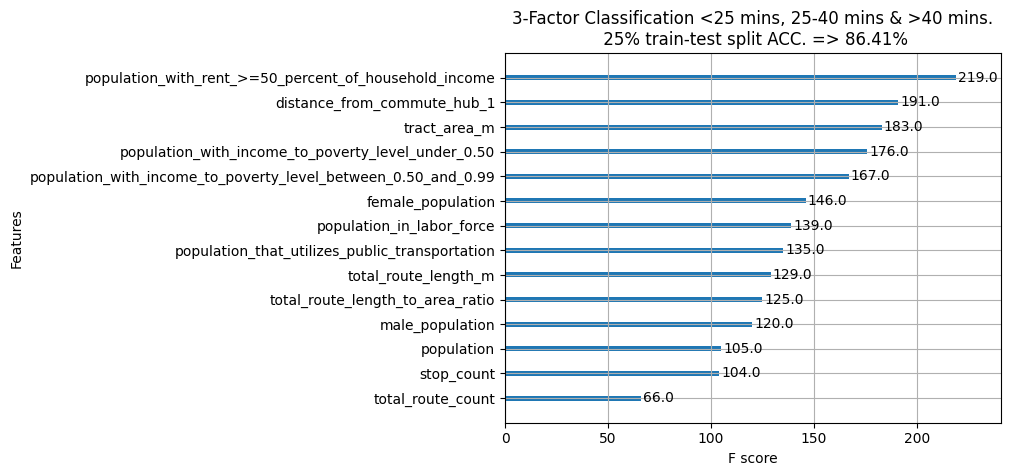

In [156]:
y= []
for i,row in census_df.iterrows():
    y1 = row[1:6].sum() # 0-25 mins
    y2 = row[6:9].sum() # 25-40 mins
    y3 = row[9:13].sum() # 40- >90 mins
    if ((y1> y2) and (y1>y3)):
        y.append(0)
    elif ((y2> y1) and (y2>y3)):
        y.append(1)
    else:
        y.append(2)


seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_importance(model)
plt.title("3-Factor Classification <25 mins, 25-40 mins & >40 mins.\n 25% train-test split ACC. => 86.41%")
plt.show()

## Outputting CSV file for use in mlr.r

In [158]:
tract_df["mean_time"] = census_df["Mean Time"]
tract_df.to_csv(r_preprocessed_data)

# 3. Scratch Code for Testing